# Imports and Config

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import os
import re
import emoji
import random

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

import unicodedata
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import gc
import torch
import torch.nn.functional as F

from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class NbCfg:
    media = "General"
    text_col = "text"
    target_col = "labels"
    model_name = "/kaggle/input/huggingface-models/deberta-base"
    seed = 42
    n_splits = 3
    max_len = 64
    dropout = 0.3
    n_accumulate=1
    print_freq = 250
    min_lr = 1e-7
    scheduler = 'cosine'
    batch_size = 64
    num_workers = 3
    lr = 2e-5
    weight_decay = 0.01
    epochs = 5
    train = True 
    num_warmup_steps = 0
    num_cycles=0.5
    debug = True

# Data Loading

In [9]:
train_data = pd.read_csv("/kaggle/input/truth-tell-dataset/combined_data.csv")
train_data = train_data.dropna()
print("length of dastaset before duplicate removal" , len(train_data))
train_data = train_data.drop_duplicates()
print("length of dastaset after duplicate removal" , len(train_data))
train_data['labels'] = train_data['labels'].replace({True: 'Real', False: 'Fake'})


if NbCfg.debug:
    train_data = train_data.sample(10000, ignore_index=True)

length of dastaset before duplicate removal 67770
length of dastaset after duplicate removal 50077


In [10]:
train_data.head()


,labels,text
0,Real,ISTANBUL (Reuters) - President Tayyip Erdogan ...
1,Fake,Just when you didn t think the Trump campaign ...
2,Fake,Eleven-year-old Marley Dias always wanted to b...
3,Real,MADRID (Reuters) - The Spanish government will...
4,Fake,Nebraska Senator Ben Sasse gives a fantastic a...


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  10000 non-null  object
 1   text    10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [13]:
train_data.shape

(10000, 2)

In [14]:

train_data['text'][0]

'ISTANBUL (Reuters) - President Tayyip Erdogan said Turkey may shut its border with northern Iraq  at any moment  after closing its air space to the region, Hurriyet newspaper reported on Thursday, reviving a threat first made after Kurds there voted for independence.  We have completely closed our air space to the regional government in northern Iraq,  the paper cited Erdogan as telling reporters on his plane returning from a trip to Poland.  Talks are continuing on what will be done regarding the land (border) ... We have not shut the border gates yet but this could happen too at any moment,  he added. Turkey announced on Monday it was closing its air space to the semi-autonomous Kurdish region and said it would work to hand control of the main border crossing into the region to the central Iraqi government. The Habur gate is the main transit point between Turkey and Iraq s semi-autonomous Kurdish Regional Government.  A Sept. 25 referendum, in which Kurds in northern Iraq voted over

# Data Preprocessing

In [15]:
stop_words = set(stopwords.words('english'))

english_contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'd've": "I would have",
    "I'll": "I will",
    "I'll've": "I will have",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text):
    for contraction, full_form in english_contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', full_form, text)
    return text

def normalize_text(text):
    text = text.lower()
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r"n't", ' not', text)
    return text

In [16]:
def preprocess_text(text):
    # Remove emojis
    text = emoji.demojize(text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Expand contractions
    text = expand_contractions(text)

    # Normalize text (e.g., café -> cafe)
    text = normalize_text(text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove hashtags but keep the words
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()


    return text

In [17]:
tqdm.pandas() 
train_data[NbCfg.text_col] = train_data[NbCfg.text_col].progress_apply(preprocess_text)

100%|██████████| 10000/10000 [01:12<00:00, 137.24it/s]


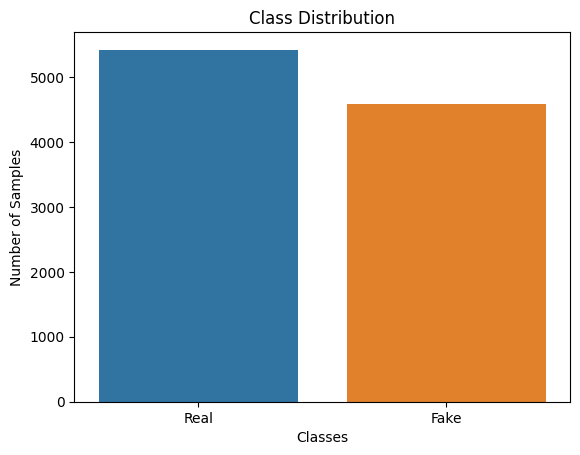

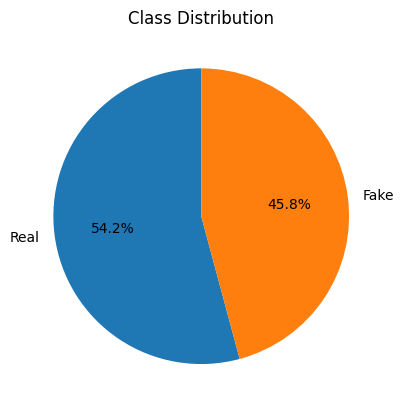

In [18]:

class_distribution = train_data['labels'].value_counts()

# Bar Plot
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

# Pie Chart
class_distribution.plot.pie(autopct='%1.1f%%', startangle=90, labels=class_distribution.index)
plt.ylabel('')
plt.title('Class Distribution')
plt.show()


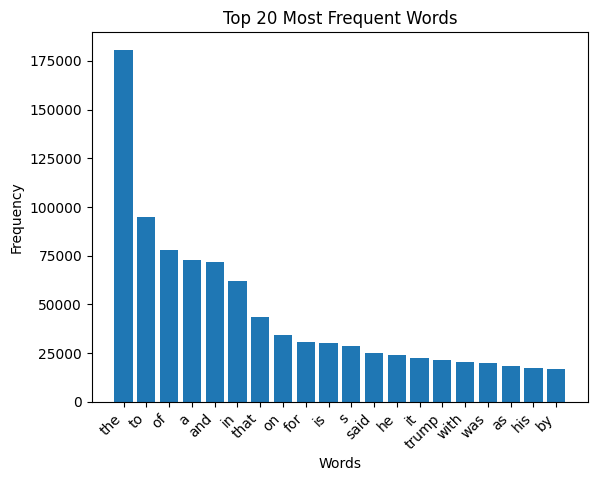

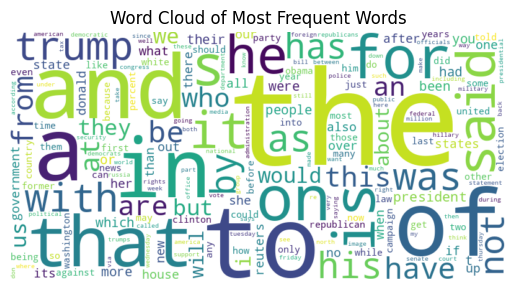

In [19]:
from collections import Counter
from wordcloud import WordCloud

tokens = ' '.join(train_data['text']).split()
word_freq = Counter(tokens)


most_common = word_freq.most_common(20)  # Top 20 words
words, counts = zip(*most_common)
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()


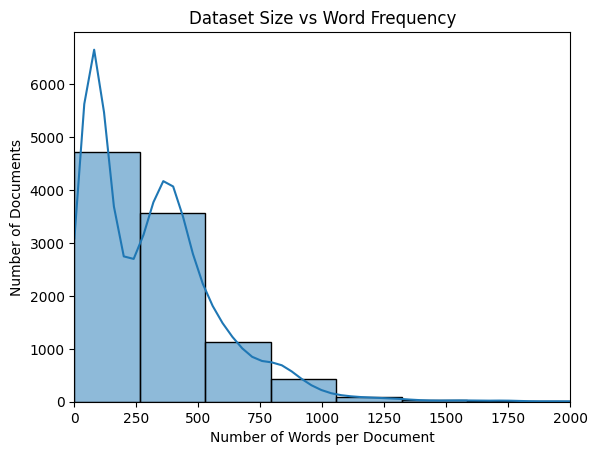

In [20]:

word_counts = train_data['text'].apply(lambda x: len(x.split()))

# Create a histogram for word frequencies
sns.histplot(word_counts, bins=30, kde=True)
plt.title('Dataset Size vs Word Frequency')
plt.xlabel('Number of Words per Document')
plt.ylabel('Number of Documents')
plt.xlim(0, 2000)
plt.show()


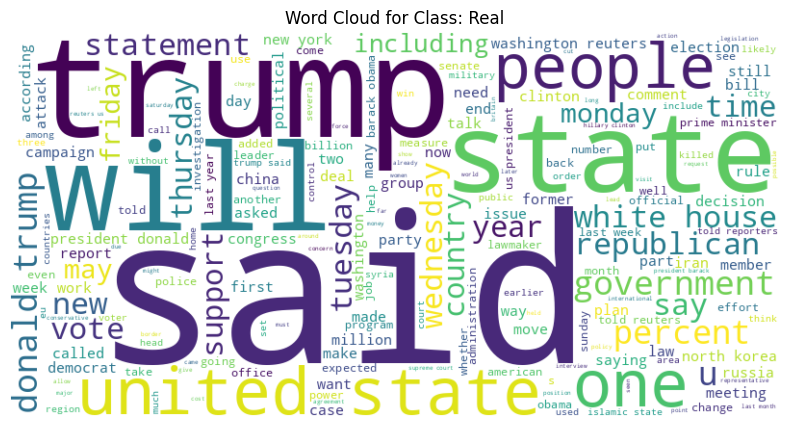

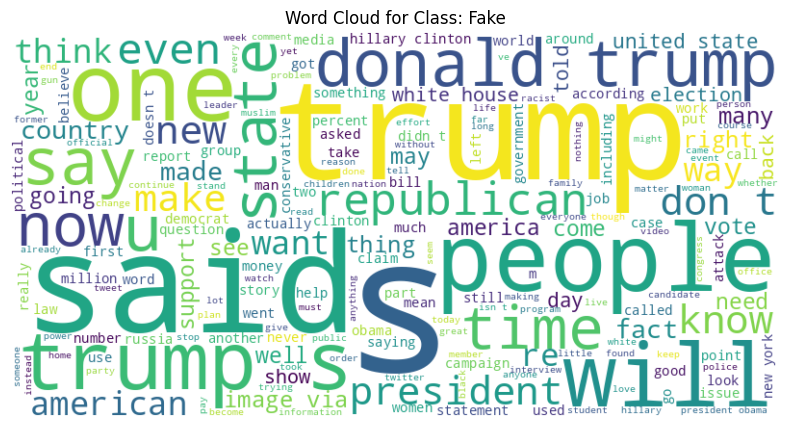

In [22]:
from wordcloud import WordCloud
# Assuming 'train_data' is your dataset with columns 'labels' and 'text'
classes = train_data['labels'].unique()

# Generate word clouds for each class
for cls in classes:
    class_text = ' '.join(train_data[train_data['labels'] == cls]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(class_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Class: {cls}')
    plt.show()


In [23]:
train_data.head()

,labels,text
0,Real,istanbul reuters president tayyip erdogan said...
1,Fake,just when you didn t think the trump campaign ...
2,Fake,elevenyearold marley dias always wanted to be ...
3,Real,madrid reuters the spanish government will hol...
4,Fake,nebraska senator ben sasse gives a fantastic a...


In [24]:
unique_labels = train_data[NbCfg.target_col].unique()

id2label = {i: unique_labels[i] for i in range(len(unique_labels))}
label2id = {v: k for k, v in id2label.items()}

In [25]:
train_data[NbCfg.target_col] = train_data[NbCfg.target_col].apply(lambda x: label2id[x])

In [26]:
class Tokenize(object):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.max_length = NbCfg.max_len
        
    def get_dataset(self, df):
        ds = Dataset.from_pandas(df)
        return ds
        
    def tokenize_function(self, example):
        tokenized_inputs = self.tokenizer(
            example[NbCfg.text_col], truncation=True, max_length=self.max_length
        )
        return tokenized_inputs
    
    def __call__(self, *dataframes):
        tokenized_datasets = []
        
        for df in dataframes:
            ds = self.get_dataset(df)
            tokenized_ds = ds.map(self.tokenize_function, batched=True)
            tokenized_datasets.append(tokenized_ds)
        
        return tokenized_datasets

In [27]:
# Loading the Tokenizer and creating the Data Collator object
tokenizer = AutoTokenizer.from_pretrained(NbCfg.model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [28]:
# Creating the Tokenize Object to Tokenize Data
tokenizer_obj = Tokenize(tokenizer)

# Modelling

In [29]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    macro_f1 = f1_score(labels, predictions, average="macro")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "macro_f1": macro_f1}

In [30]:
train_data.shape

(10000, 2)

In [31]:

def cleanup(checkpoint_dir):
    if os.path.exists(checkpoint_dir):
        shutil.rmtree(checkpoint_dir)

kfold = StratifiedKFold(n_splits=NbCfg.n_splits, shuffle=True, random_state=NbCfg.seed)
oof_preds = np.zeros((len(train_data), ))


for fold, (train_idx, val_idx) in enumerate(kfold.split(train_data, train_data[NbCfg.target_col])):
    print('\n')
    print(40*'=', f'FOLD: {fold}', 40*'=')
    
    train_df = train_data.iloc[train_idx]
    val_df = train_data.iloc[val_idx]
    
    train_tokenized, val_tokenized = tokenizer_obj(train_df, val_df)
    
    # Create the Model 
    model = AutoModelForSequenceClassification.from_pretrained(
        NbCfg.model_name, num_labels=len(unique_labels), id2label=id2label, label2id=label2id
    ).to(device)
    
    # Model Training
    output_dir = f"/kaggle/working/{NbCfg.model_name}_fold_{fold}"
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=NbCfg.lr,
        per_device_train_batch_size=NbCfg.batch_size,
        per_device_eval_batch_size=NbCfg.batch_size,
        num_train_epochs=NbCfg.epochs,
        weight_decay=NbCfg.weight_decay,
        evaluation_strategy="epoch",
        metric_for_best_model="macro_f1",
        save_strategy="epoch",
        logging_steps=10,
        load_best_model_at_end=True,
        report_to="none",
        warmup_ratio=NbCfg.num_warmup_steps,
        lr_scheduler_type=NbCfg.scheduler,
        optim='adamw_torch',
        logging_first_step=True,
        save_total_limit=1  # Keep only the best model
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )
    
    trainer.train()
    
    # Predicting for Out Of Fold Predictions
    logits = torch.tensor(trainer.predict(val_tokenized).predictions)
    y_preds = np.argmax(F.softmax(logits, dim=-1), axis=1)
    oof_preds[val_df.index.values] = y_preds
    

    
    # Clean up checkpoints to save space
    cleanup(output_dir)




======================================== FOLD: 0 ========================================


Map:   0%|          | 0/6666 [00:00<?, ? examples/s]

Map:   0%|          | 0/3334 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-models/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.171500,0.186333,0.883323,0.880071
2,0.174300,0.202214,0.883023,0.882760
3,0.122100,0.228521,0.886623,0.885098
4,0.106900,0.289453,0.884523,0.883273
5,0.061000,0.324431,0.887223,0.886363




======================================== FOLD: 1 ========================================


Map:   0%|          | 0/6667 [00:00<?, ? examples/s]

Map:   0%|          | 0/3333 [00:00<?, ? examples/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingface-models/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.221600,0.181317,0.885689,0.885457


KeyboardInterrupt: 

In [33]:
print("Training Finished...")
print("Performance on Evaluation Data...\n")

true_labels = train_data[NbCfg.target_col].values
macro_f1_oof = f1_score(true_labels, oof_preds, average="macro")

print(f"Macro-F1 for {NbCfg.model_name.split('/')[-1]} on Training data is: {macro_f1_oof:.3f}")
print(f"\nClassification report for Training: \n {classification_report(y_true=true_labels, y_pred=oof_preds)}")

model_save_path = './saved_model'
tokenizer_save_path = './saved_tokenizer'

# Create directories if they don't exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(tokenizer_save_path, exist_ok=True)

# Save the model and tokenizer
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

Training Finished...
Performance on Evaluation Data...

Macro-F1 for deberta-base on Training data is: 0.595

Classification report for Training: 
               precision    recall  f1-score   support

           0       0.62      0.97      0.75      5419
           1       0.88      0.29      0.44      4581

    accuracy                           0.66     10000
   macro avg       0.75      0.63      0.60     10000
weighted avg       0.74      0.66      0.61     10000

Model saved to ./saved_model
Tokenizer saved to ./saved_tokenizer
